In [130]:
##install modules

ERROR: Could not find a version that satisfies the requirement acetools (from versions: none)
ERROR: No matching distribution found for acetools


In [76]:
from googleapiclient.discovery import build
from dateutil import parser
import pandas as pd
from IPython.display import JSON

# Data viz packages
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
import re

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shanthankasula/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/shanthankasula/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [77]:
api_key = 'XXXX'

In [78]:
channel_ids = ['UCtxD0x6AuNNqdXO9Wp5GHew',
              #enter moer channels
              ]

In [79]:
 api_service_name = "youtube"
api_version = "v3"

# Get credentials and create an API client
youtube = build(
api_service_name, api_version, developerKey=api_key)

In [80]:
def get_channel_stats(youtube, channel_ids):
    all_data = []
    request = youtube.channels().list(
    part="snippet,contentDetails,statistics",
    id=','.join(channel_ids)
    )
    response = request.execute()
    
    #loop through items
    for item in response['items']:
        data = {'channelName': item['snippet']['title'],
                'subscribers': item['statistics']['subscriberCount'],
                'views': item['statistics']['viewCount'],
                'totalVideos': item['statistics']['videoCount'],
                'playlistId': item['contentDetails']['relatedPlaylists']['uploads']
        }
        all_data.append(data)
    return (pd.DataFrame(all_data))

In [81]:
channel_stats = get_channel_stats(youtube, channel_ids)

In [111]:
channel_stats

,channelName,subscribers,views,totalVideos,playlistId
0,UR · Cristiano,62100000,486894238,39,UUtxD0x6AuNNqdXO9Wp5GHew


In [83]:
# Convert count columns to numeric columns
numeric_cols = ['subscribers', 'views', 'totalVideos']
channel_stats[numeric_cols] = channel_stats[numeric_cols].apply(pd.to_numeric, errors='coerce')

## Subscriber Count

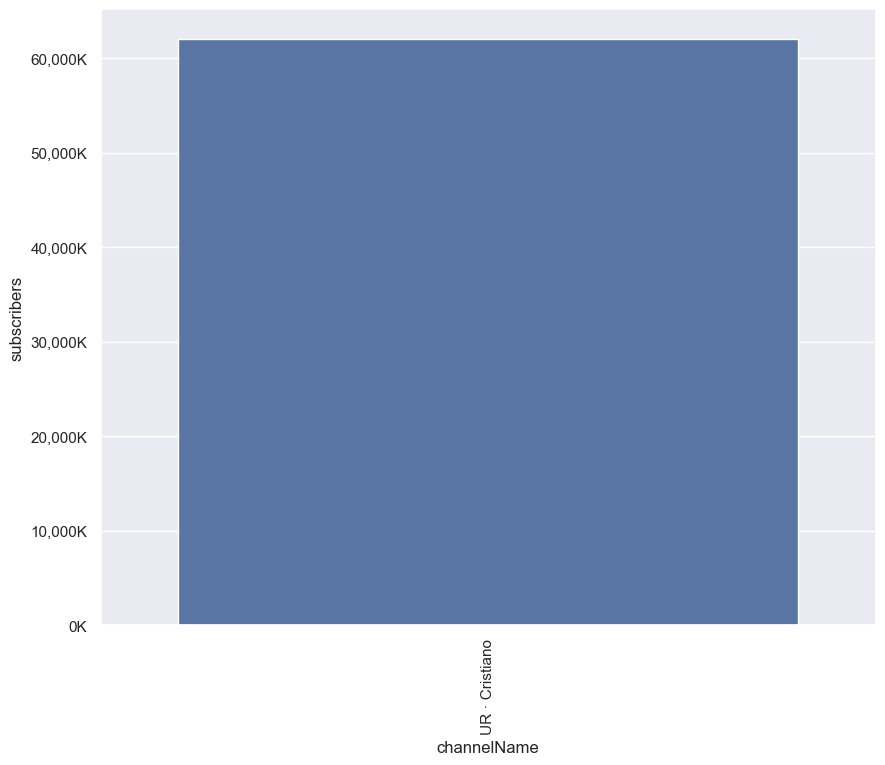

In [84]:
sns.set(rc={'figure.figsize':(10,8)})
ax = sns.barplot(x='channelName', y='subscribers', data=channel_stats.sort_values('subscribers', ascending=False))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))
plot = ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

In [85]:
playlist_id = 'UUtxD0x6AuNNqdXO9Wp5GHew'

def get_video_ids(youtube, playlist_id):
    
    video_ids = []
    
    request = youtube.playlistItems().list(
            part="snippet, contentDetails",
            playlistId="UUtxD0x6AuNNqdXO9Wp5GHew",
            maxResults = 50
        )
    response = request.execute()
    
    for item in response ['items']:
        video_ids.append(item['contentDetails']['videoId'])
    
    next_page_token = response.get('nextPageToken')
    while next_page_token is not None:
        request = youtube.playlistItems().list(
                    part='contentDetails',
                    playlistId = playlist_id,
                    maxResults = 50,
                    pageToken = next_page_token)
        response = request.execute()

        for item in response['items']:
            video_ids.append(item['contentDetails']['videoId'])

        next_page_token = response.get('nextPageToken')
        
    return video_ids

In [86]:
video_ids = get_video_ids(youtube, playlist_id)

In [87]:
len(video_ids)

39

In [90]:
def get_video_details(youtube, video_ids):

    all_video_info = []
    
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute() 

        for video in response['items']:
            stats_to_keep = {'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                             'statistics': ['viewCount', 'likeCount', 'favouriteCount', 'commentCount'],
                             'contentDetails': ['duration', 'definition', 'caption']
                            }
            video_info = {}
            video_info['video_id'] = video['id']

            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None

            all_video_info.append(video_info)
    
    return pd.DataFrame(all_video_info)

In [91]:
video_df = get_video_details(youtube, video_ids)

In [92]:
video_df.head(5)

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption
0,YuVZMQzryo8,UR · Cristiano,¡Jugué contra el n1 de pádel del mundo! ¿Quién...,Cristiano Ronaldo jugó en Madrid contra Arturo...,None,2024-09-18T13:00:40Z,779446,138158,None,8714,PT2M46S,hd,true
1,GWDnCgb_XgY,UR · Cristiano,I beat THE BEST Padel player in the world,#cristianoronaldo #padel #urcristiano #arturoc...,None,2024-09-17T09:30:24Z,1202988,203381,None,6970,PT41S,hd,false
2,WAz6enaA9nE,UR · Cristiano,Cristiano Ronaldo: This is how Manchester Unit...,Cristiano Ronaldo and Rio Ferdinand talk about...,None,2024-09-12T07:00:08Z,6232684,561431,None,26537,PT9M4S,hd,false
3,UyV8pwPpLJQ,UR · Cristiano,Cristiano Ronaldo reveals the biggest secret o...,"Mbappé, Kroos... and why Real Madrid is the bi...",None,2024-09-10T13:00:08Z,4850002,573794,None,23830,PT9M28S,hd,false
4,0kaEMM58_AY,UR · Cristiano,Las 5 cosas que NO SABÍAS sobre Cristiano Rona...,El reto más divertido entre Georgina Rodríguez...,None,2024-09-09T13:42:17Z,4230747,504604,None,22485,PT14M39S,hd,false


In [116]:
def get_comments_in_videos(youtube, video_ids):
    """
    Get top level comments as text from all videos with given IDs (only the first 10 comments due to quote limit of Youtube API)
    Params:
    
    youtube: the build object from googleapiclient.discovery
    video_ids: list of video IDs
    
    Returns:
    Dataframe with video IDs and associated top level comment in text.
    
    """
    all_comments = []
    
    for video_id in video_ids:
        try:   
            request = youtube.commentThreads().list(
                part="snippet,replies",
                videoId=video_id
            )
            response = request.execute()
        
            comments_in_video = [comment['snippet']['topLevelComment']['snippet']['textOriginal'] for comment in response['items']]
            comments_in_video_info = {'video_id': video_id, 'comments': comments_in_video}

            all_comments.append(comments_in_video_info)
            
        except: 
            # When error occurs - most likely because comments are disabled on a video
            print('Could not get comments for video ' + video_id)
        
    return pd.DataFrame(all_comments) 

In [117]:
comments_df = get_comments_in_videos(youtube, video_ids)

Could not get comments for video YuVZMQzryo8


In [118]:
comments_df

,video_id,comments
0,GWDnCgb_XgY,"[siuuuuu, RNlDO, ❤❤❤, Hello Cristiano my name ..."
1,WAz6enaA9nE,[Halo Ronaldo saya dari Indonesia saya sudah s...
2,UyV8pwPpLJQ,"[Siuuuu, 😘🇵🇹🐐🇸🇾🇸🇾, Thần tượng lớn nhất của tôi..."
3,0kaEMM58_AY,"[SIUUUUUUUUUUUUUU 900 goles goals, Cr 😢❤, ‏‪3:..."
4,erY6UaPXTHE,[رنالدو تو بهترین در دنیایی من ترفتارتم ❤❤❤❤❤❤...
5,PX8ykesLfSE,"[❤, foot challenge with messi will break youtu..."
6,9KXHnqrXZhk,[CR7 ❤❤❤❤❤ Ronaldo ❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤💗💗💗💗❤❤❤❤💓💓...
7,IcdCe7afa8c,"[زیبا❤🇮🇷🇮🇷, Congratulations 🎉🎉🎉, CR7 tou com ..."
8,etps-RdsTz0,"[Siuuuuuu, She two eye balls and…., ❤❤❤❤🎉🎉🎉🎉Ol..."
9,e9CkkiPCo30,"[Você é ótimo, Ronaldo, somos seus fãs ❤❤❤❤❤🎉🎉..."


## Save as csv files

In [119]:
# Write video data to CSV file for future references
video_df.to_csv('video_data_top10_channels.csv')
comments_df.to_csv('comments_data_top10_channels.csv')

## Data pre-processing:

In [96]:
video_df.isnull().any()

video_id          False
channelTitle      False
title             False
description       False
tags               True
publishedAt       False
viewCount         False
likeCount         False
favouriteCount     True
commentCount      False
duration          False
definition        False
caption           False
dtype: bool

In [97]:
video_df.dtypes

video_id          object
channelTitle      object
title             object
description       object
tags              object
publishedAt       object
viewCount         object
likeCount         object
favouriteCount    object
commentCount      object
duration          object
definition        object
caption           object
dtype: object

In [98]:
# Convert count columns to numeric
numeric_cols = ['viewCount', 'likeCount', 'favouriteCount', 'commentCount']
video_df[numeric_cols] = video_df[numeric_cols].apply(pd.to_numeric, errors = 'coerce', axis = 1)

In [99]:
# Publish day in the week
video_df['publishedAt'] = video_df['publishedAt'].apply(lambda x: parser.parse(x)) 
video_df['pushblishDayName'] = video_df['publishedAt'].apply(lambda x: x.strftime("%A")) 

In [100]:
# convert duration to seconds
import isodate
video_df['durationSecs'] = video_df['duration'].apply(lambda x: isodate.parse_duration(x))
video_df['durationSecs'] = video_df['durationSecs'].astype('timedelta64[s]')

In [101]:
video_df[['durationSecs', 'duration']] 


,durationSecs,duration
0,166.0,PT2M46S
1,41.0,PT41S
2,544.0,PT9M4S
3,568.0,PT9M28S
4,879.0,PT14M39S
5,28.0,PT28S
6,164.0,PT2M44S
7,113.0,PT1M53S
8,18.0,PT18S
9,25.0,PT25S


In [102]:
# Add tag count
video_df['tagCount'] = video_df['tags'].apply(lambda x: 0 if x is None else len(x))


In [103]:
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption,pushblishDayName,durationSecs,tagCount
0,YuVZMQzryo8,UR · Cristiano,¡Jugué contra el n1 de pádel del mundo! ¿Quién...,Cristiano Ronaldo jugó en Madrid contra Arturo...,None,2024-09-18 13:00:40+00:00,779446.0,138158.0,NaN,8714.0,PT2M46S,hd,true,Wednesday,166.0,0
1,GWDnCgb_XgY,UR · Cristiano,I beat THE BEST Padel player in the world,#cristianoronaldo #padel #urcristiano #arturoc...,None,2024-09-17 09:30:24+00:00,1202988.0,203381.0,NaN,6970.0,PT41S,hd,false,Tuesday,41.0,0
2,WAz6enaA9nE,UR · Cristiano,Cristiano Ronaldo: This is how Manchester Unit...,Cristiano Ronaldo and Rio Ferdinand talk about...,None,2024-09-12 07:00:08+00:00,6232684.0,561431.0,NaN,26537.0,PT9M4S,hd,false,Thursday,544.0,0
3,UyV8pwPpLJQ,UR · Cristiano,Cristiano Ronaldo reveals the biggest secret o...,"Mbappé, Kroos... and why Real Madrid is the bi...",None,2024-09-10 13:00:08+00:00,4850002.0,573794.0,NaN,23830.0,PT9M28S,hd,false,Tuesday,568.0,0
4,0kaEMM58_AY,UR · Cristiano,Las 5 cosas que NO SABÍAS sobre Cristiano Rona...,El reto más divertido entre Georgina Rodríguez...,None,2024-09-09 13:42:17+00:00,4230747.0,504604.0,NaN,22485.0,PT14M39S,hd,false,Monday,879.0,0
5,erY6UaPXTHE,UR · Cristiano,Cristiano Ronaldo's COOLEST outfit ever!,#cr7 #urcristiano #cristianoronaldo,None,2024-09-09 10:37:43+00:00,2970229.0,441702.0,NaN,15776.0,PT28S,hd,false,Monday,28.0,0
6,PX8ykesLfSE,UR · Cristiano,Beckham or Giggs? Benzema or Mbappé? Cristiano...,Cristiano Ronaldo and Rio Ferdinand have fun i...,None,2024-09-08 13:01:14+00:00,5619794.0,669263.0,NaN,24640.0,PT2M44S,hd,false,Sunday,164.0,0
7,9KXHnqrXZhk,UR · Cristiano,Watch Cristiano Ronaldo’s 900th goal from all ...,#urcristiano #cr7 #cristianoronaldo,None,2024-09-07 13:00:05+00:00,4499596.0,727067.0,NaN,34297.0,PT1M53S,hd,false,Saturday,113.0,0
8,IcdCe7afa8c,UR · Cristiano,900 career goals!,#cr7 #urcristiano #cristianoronaldo,None,2024-09-05 20:12:01+00:00,6172607.0,1226449.0,NaN,40636.0,PT18S,hd,false,Thursday,18.0,0
9,etps-RdsTz0,UR · Cristiano,"Cristiano Ronaldo diciendo ""Qué mirás bobo""!",#urcristiano #cr7 #cristianoronaldo,None,2024-09-04 12:48:36+00:00,3905069.0,610540.0,NaN,16963.0,PT25S,hd,false,Wednesday,25.0,0


# EDA:


## Best Performing Videos:

/Users/shanthankasula/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


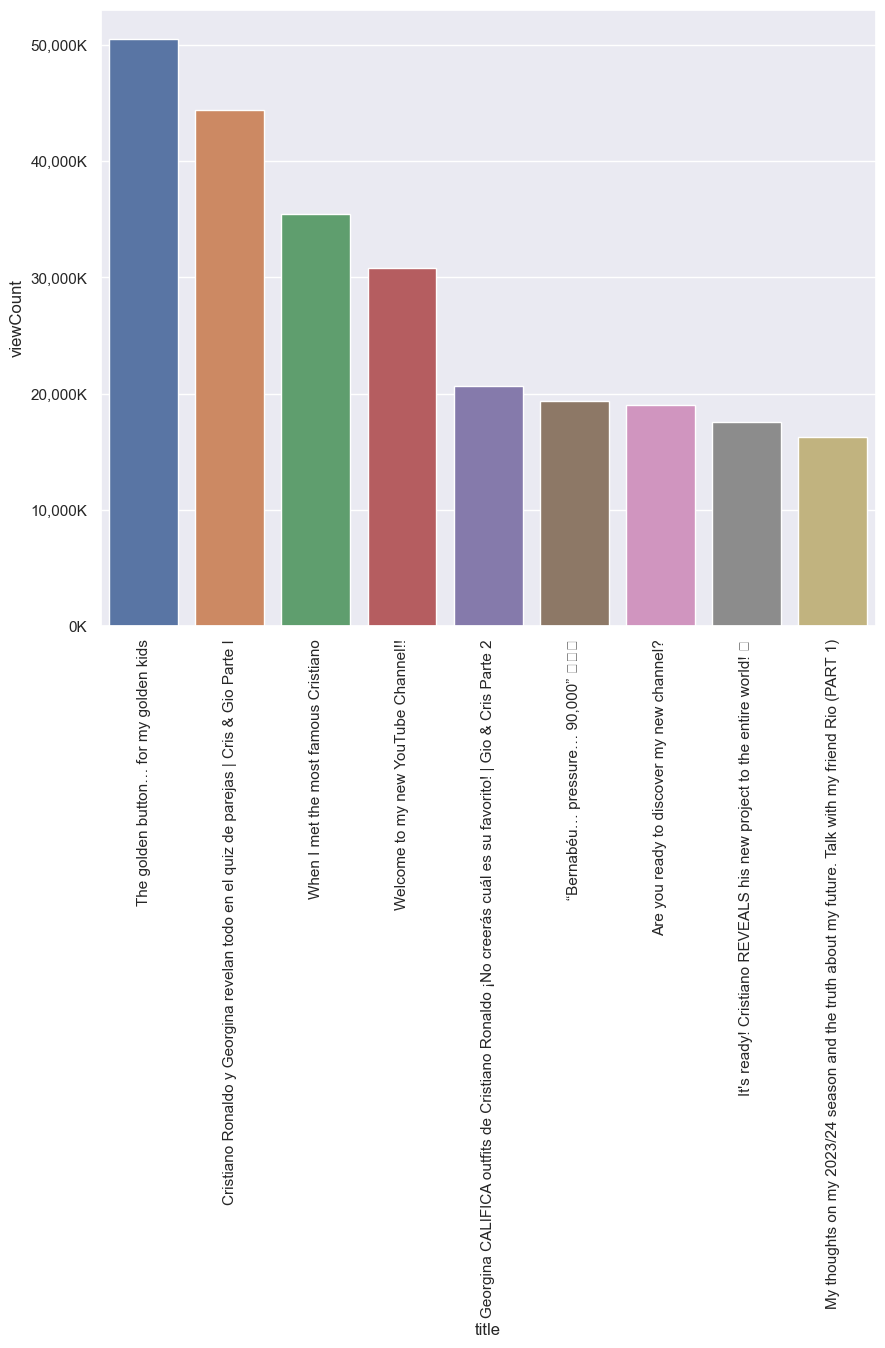

In [104]:
ax = sns.barplot(x = 'title', y = 'viewCount', data = video_df.sort_values('viewCount', ascending=False)[0:9])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))

### Worst Performing Videos:

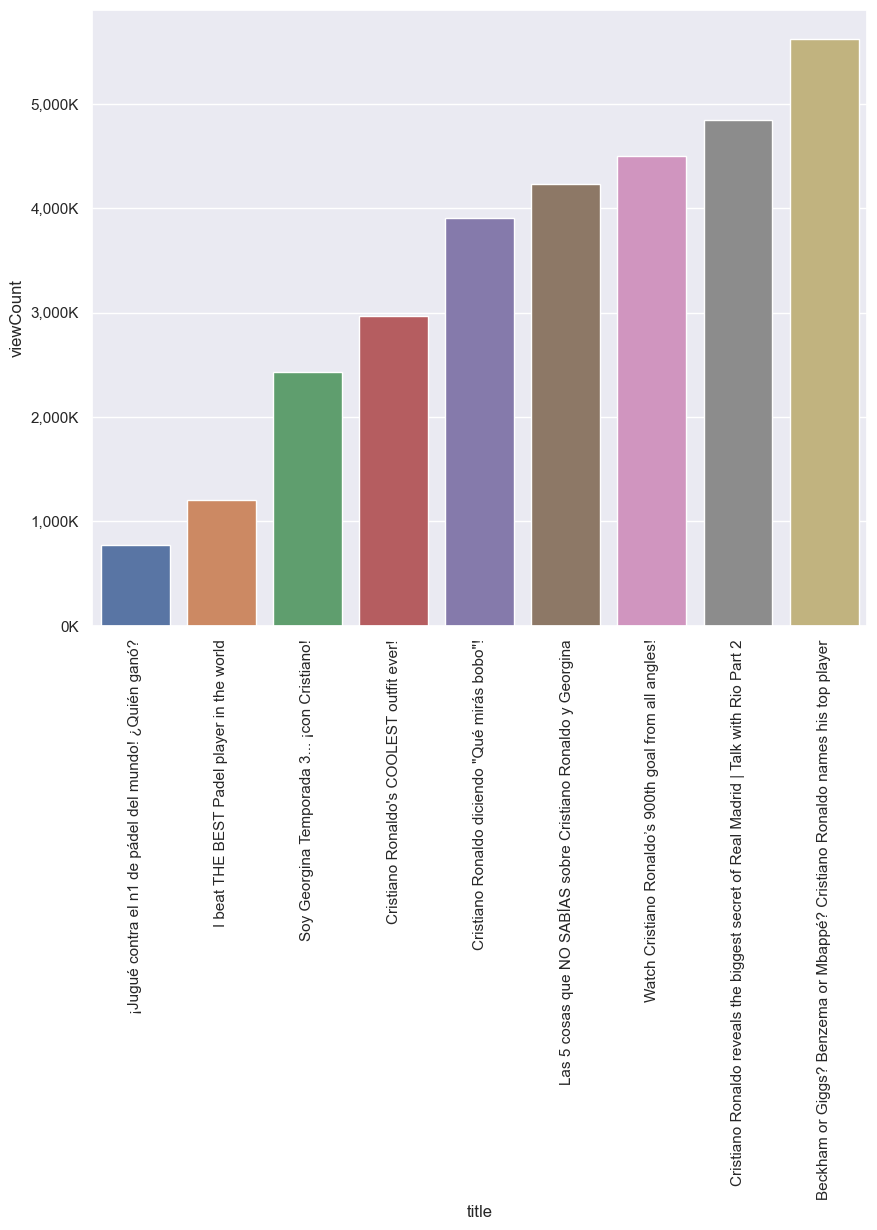

In [105]:
ax = sns.barplot(x = 'title', y = 'viewCount', data = video_df.sort_values('viewCount', ascending=True)[0:9])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))

## View Distribution Per Video

/Users/shanthankasula/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='channelTitle', ylabel='viewCount'>

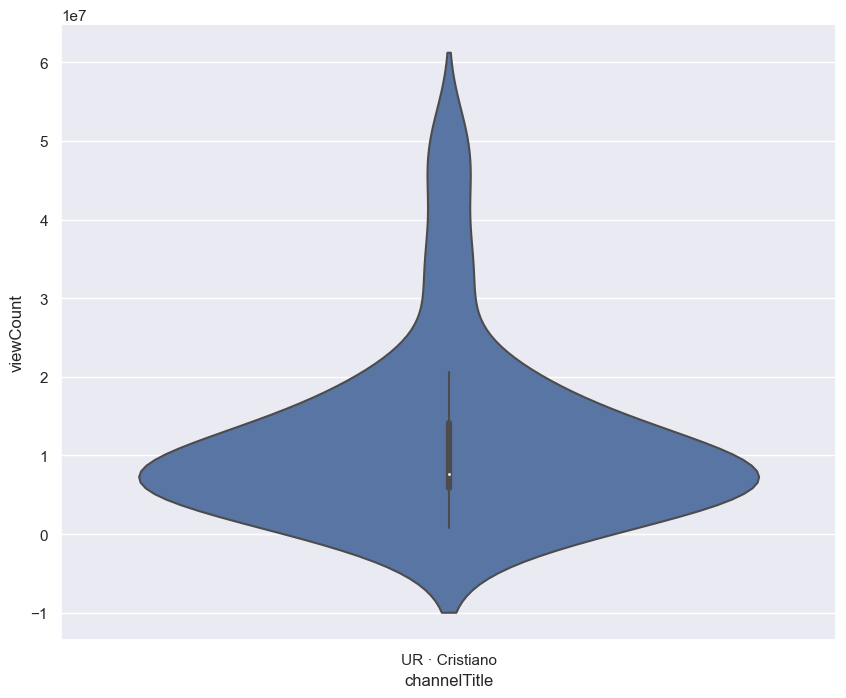

In [106]:
sns.violinplot(video_df['channelTitle'], video_df['viewCount'])

## Views vs. likes and comments

<AxesSubplot:xlabel='likeCount', ylabel='viewCount'>

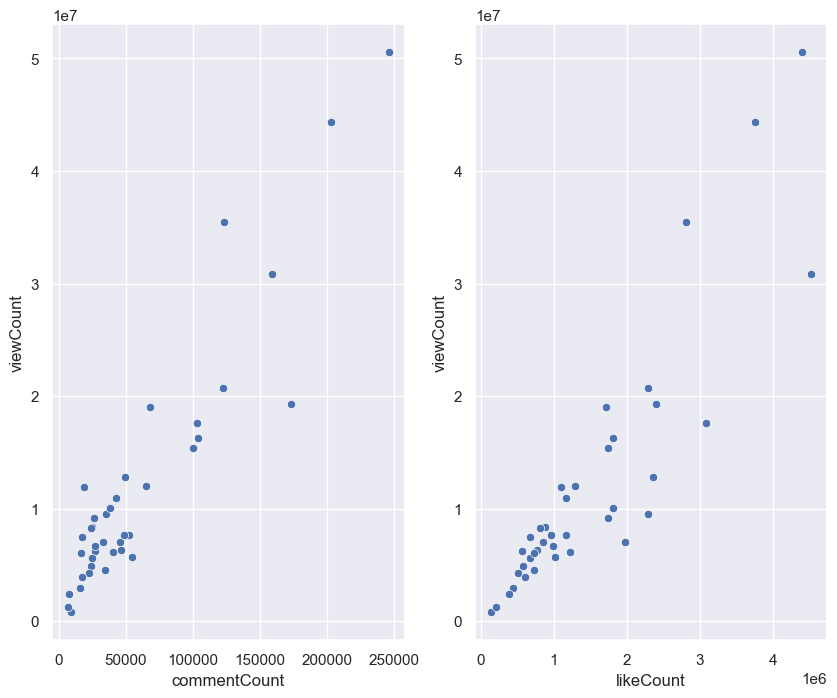

In [107]:
fig, ax = plt.subplots(1,2)
sns.scatterplot(data = video_df, x = 'commentCount', y = 'viewCount', ax = ax[0])
sns.scatterplot(data = video_df, x = 'likeCount', y = 'viewCount', ax = ax[1])

## Avg Video Duration:

<AxesSubplot:xlabel='durationSecs', ylabel='Count'>

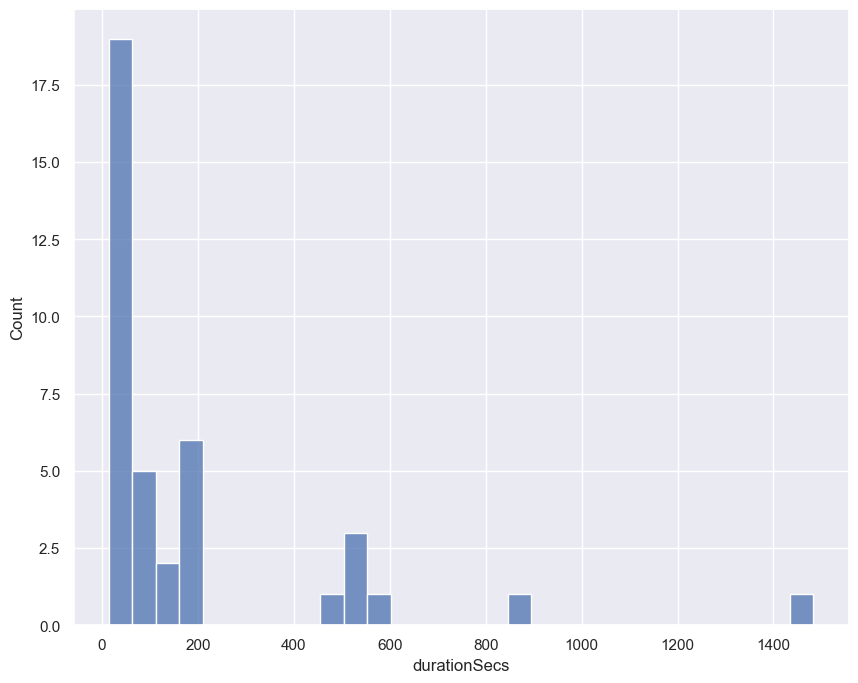

In [108]:
sns.histplot(data = video_df, x = 'durationSecs', bins=30)


## Wordcloud for video titles


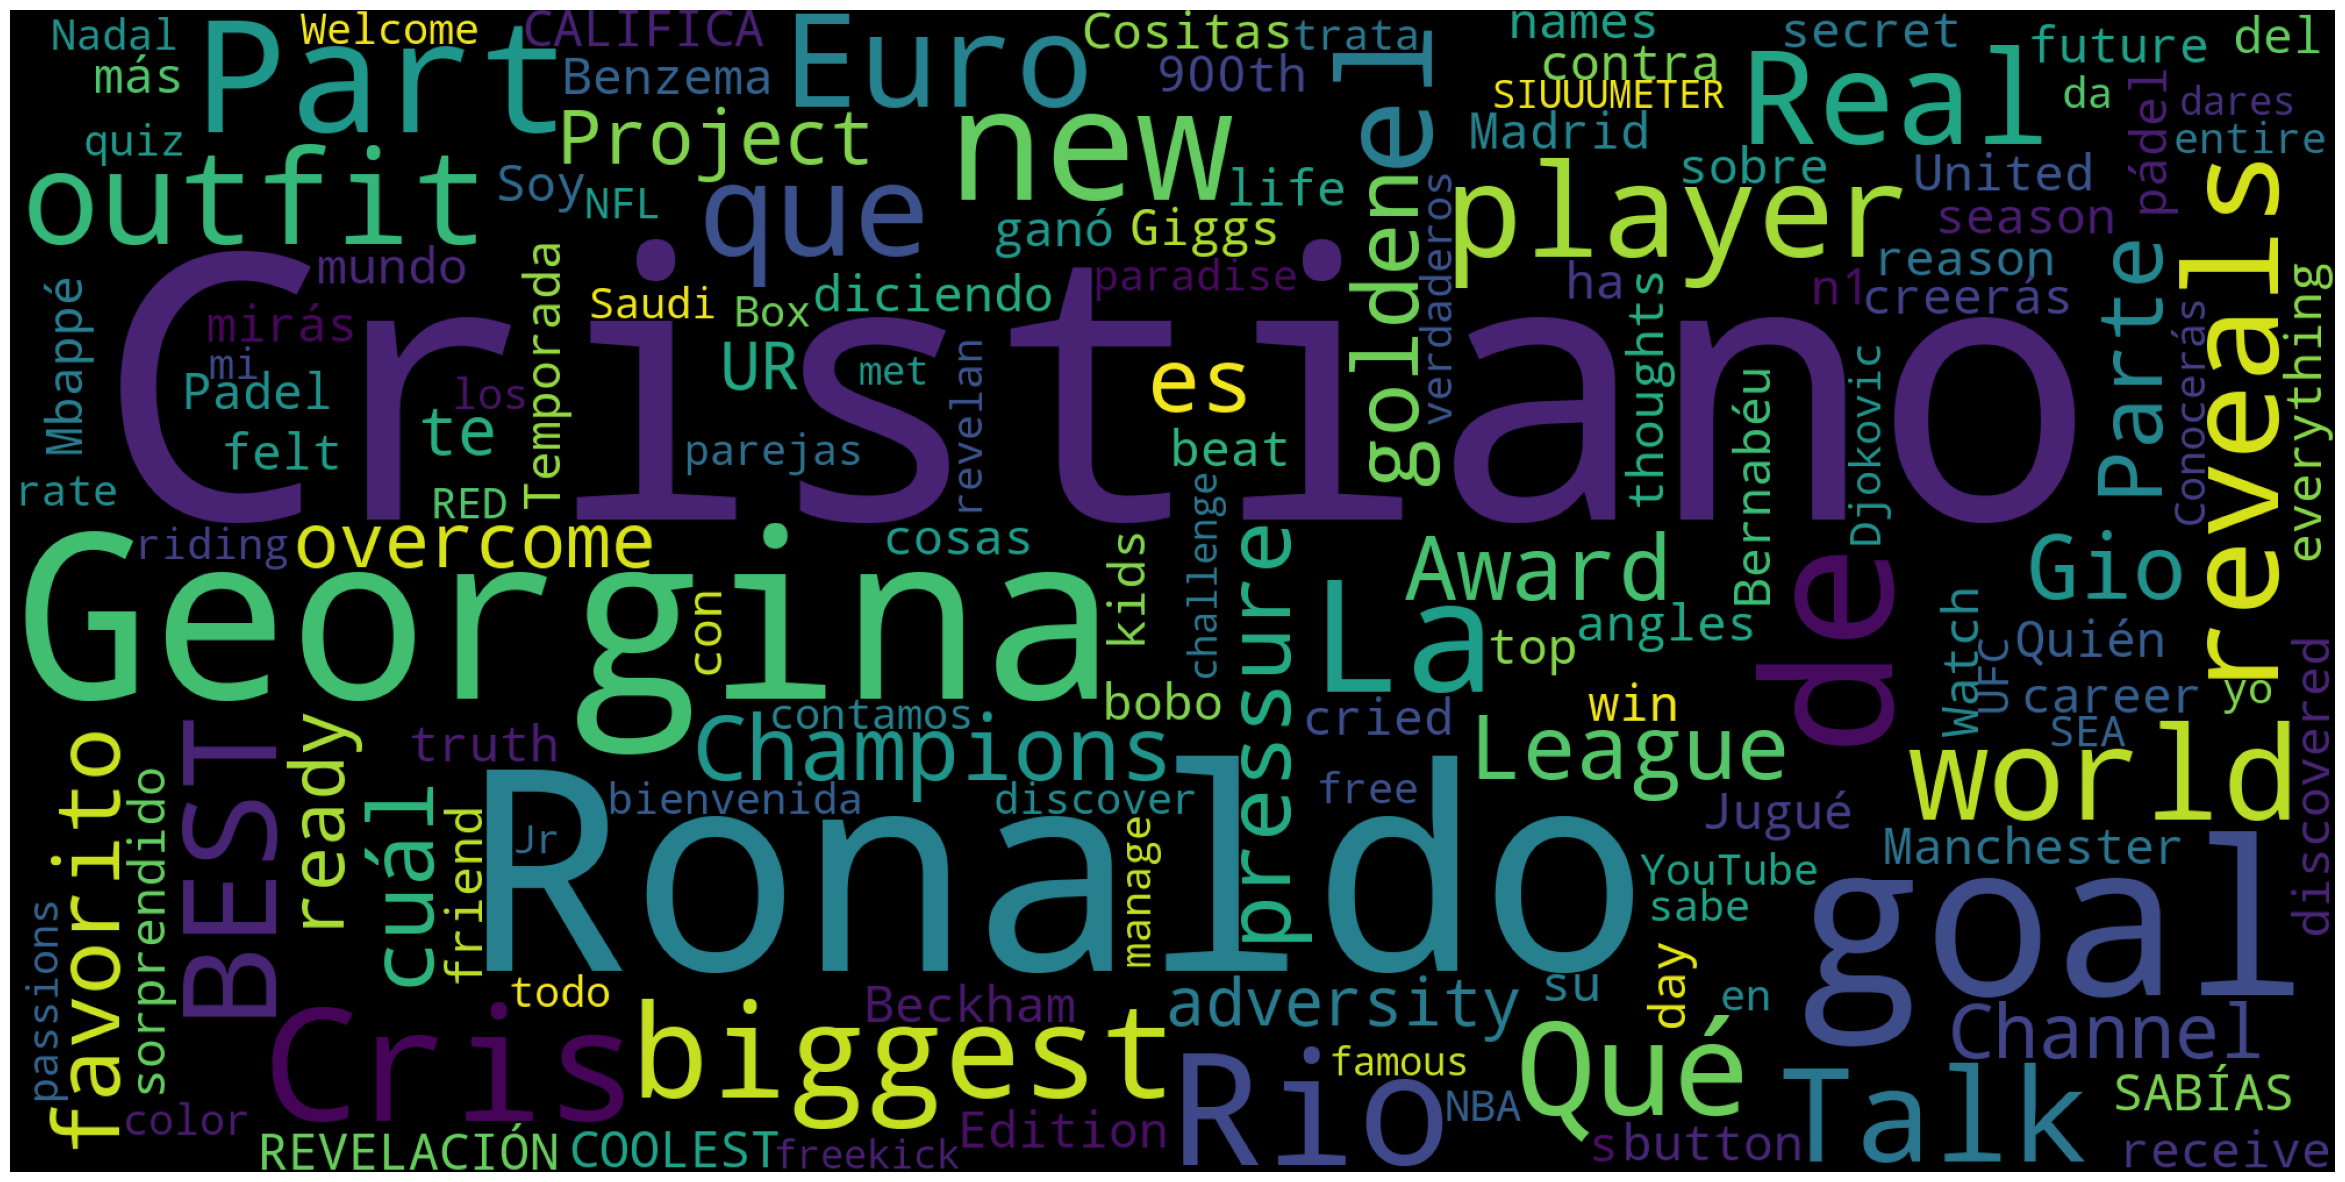

In [109]:
stop_words = set(stopwords.words('english'))
video_df['title_no_stopwords'] = video_df['title'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in video_df['title_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words) 

def plot_cloud(wordcloud):
    plt.figure(figsize=(30, 20))
    plt.imshow(wordcloud) 
    plt.axis("off");

wordcloud = WordCloud(width = 2000, height = 1000, random_state=1, background_color='black', 
                      colormap='viridis', collocations=False).generate(all_words_str)
plot_cloud(wordcloud)

## Upload schedule


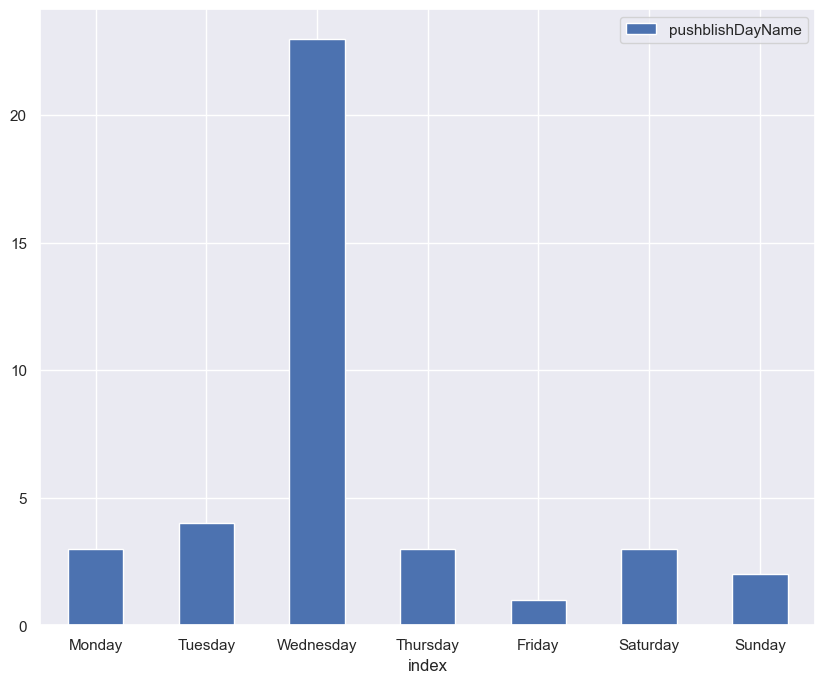

In [110]:
day_df = pd.DataFrame(video_df['pushblishDayName'].value_counts())
weekdays = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_df = day_df.reindex(weekdays)
ax = day_df.reset_index().plot.bar(x='index', y='pushblishDayName', rot=0)

## Sentiment Analysis on Comments:

In [131]:
from textblob import TextBlob

#Function to clean the comment text (removing brackets and converting list to string if necessary)
def clean_comment(comment):
    if isinstance(comment, list):
        # If the comment is a list, join the elements into a single string
        comment = ' '.join(comment)
    # Remove square brackets and quotes from the comment string
    return comment.replace("[", "").replace("]", "").replace("'", "")

# Apply the cleaning function to the comments column
comments_df['cleaned_comments'] = comments_df['comments'].apply(clean_comment)

# Perform sentiment analysis using TextBlob and extract the polarity (sentiment score)
comments_df['sentiment_polarity'] = comments_df['cleaned_comments'].apply(lambda comment: TextBlob(comment).sentiment.polarity)

print(comments_df[['video_id', 'cleaned_comments', 'sentiment_polarity']].head())


      video_id                                   cleaned_comments  \
0  GWDnCgb_XgY  siuuuuu RNlDO ❤❤❤ Hello Cristiano my name is p...   
1  WAz6enaA9nE  Halo Ronaldo saya dari Indonesia saya sudah su...   
2  UyV8pwPpLJQ  Siuuuu 😘🇵🇹🐐🇸🇾🇸🇾 Thần tượng lớn nhất của tôi Sm...   
3  0kaEMM58_AY  SIUUUUUUUUUUUUUU 900 goles goals Cr 😢❤ ‏‪3:34‬...   
4  erY6UaPXTHE  رنالدو تو بهترین در دنیایی من ترفتارتم ❤❤❤❤❤❤❤...   

   sentiment_polarity  
0            0.246991  
1            0.156250  
2            0.485714  
3            0.100000  
4            0.325000  


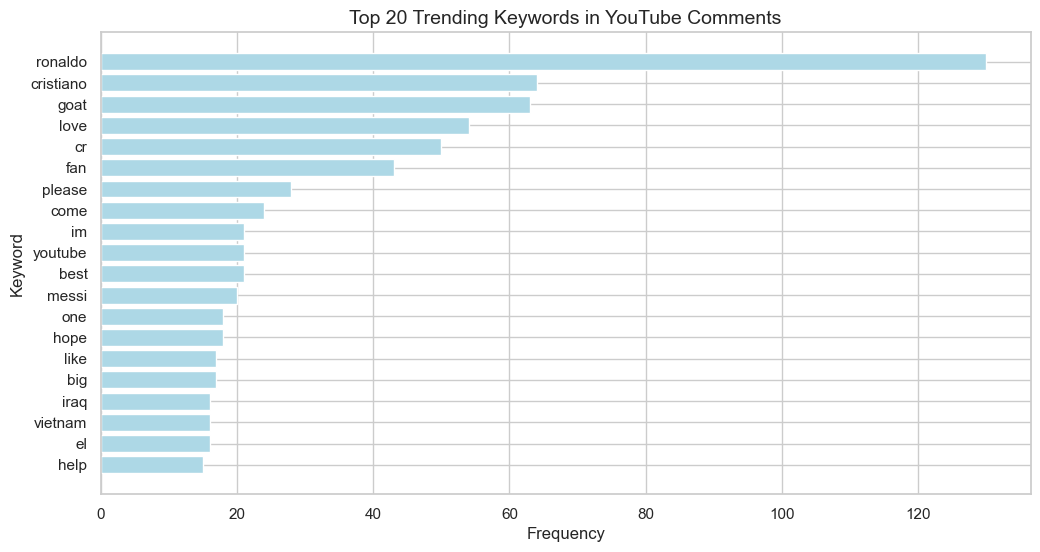

In [133]:
# Function to clean and prepare text for keyword extraction
def preprocess_text(text):
    # Remove non-alphabetic characters and convert to lowercase
    text = re.sub(r'[^a-zA-Z\s]', '', text.lower())
    return text

# Apply text preprocessing
comments_df['processed_comments'] = comments_df['cleaned_comments'].apply(preprocess_text)

# Remove stop words and create a list of processed comments
stop_words = set(stopwords.words('english'))
vectorizer = CountVectorizer(stop_words=stop_words)
word_count_matrix = vectorizer.fit_transform(comments_df['processed_comments'])

# Sum up the counts of each word
word_count = word_count_matrix.sum(axis=0)
word_freq = [(word, word_count[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
word_freq = sorted(word_freq, key=lambda x: x[1], reverse=True)

# Convert word frequency data into a DataFrame for easier visualization
keywords_df = pd.DataFrame(word_freq, columns=['Keyword', 'Frequency'])

# Visualizing the top 20 keywords
top_keywords = keywords_df.head(20)

# Plotting the most frequent keywords
plt.figure(figsize=(12, 6))
plt.barh(top_keywords['Keyword'], top_keywords['Frequency'], color='lightblue')
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Keyword', fontsize=12)
plt.title('Top 20 Trending Keywords in YouTube Comments', fontsize=14)
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()


## Avg performance by DayoftheWeek

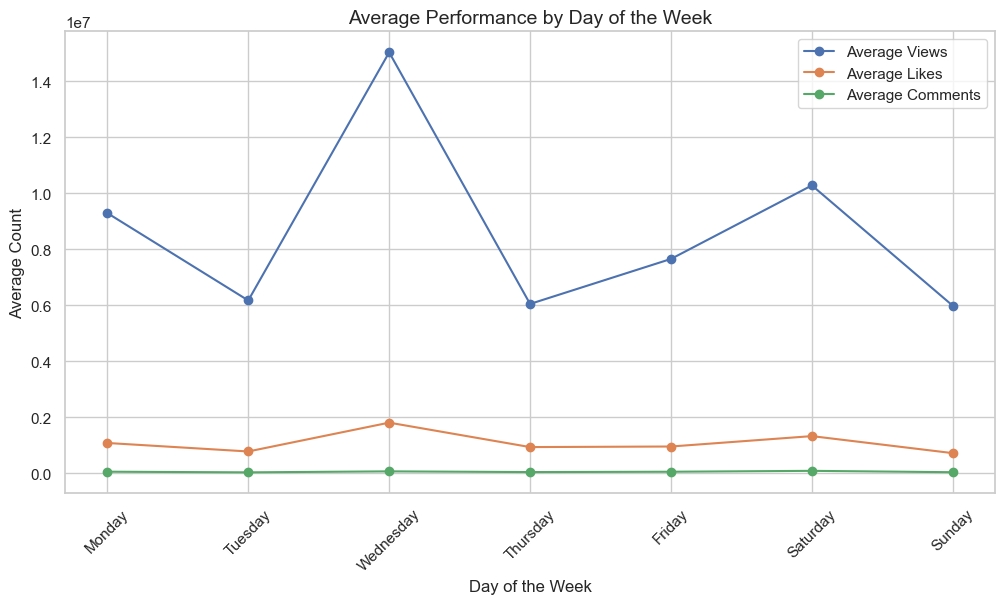

In [135]:
# Group the data by 'pushblishDayName' and calculate average views, likes, and comments per day
performance_by_day = video_df.groupby('pushblishDayName').agg({
    'viewCount': 'mean',
    'likeCount': 'mean',
    'commentCount': 'mean'
}).reset_index()

# Sort the days for better readability
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
performance_by_day['pushblishDayName'] = pd.Categorical(performance_by_day['pushblishDayName'], categories=day_order, ordered=True)
performance_by_day = performance_by_day.sort_values('pushblishDayName')

# Visualizing the performance by day of the week
plt.figure(figsize=(12, 6))

# Plot for average views
plt.plot(performance_by_day['pushblishDayName'], performance_by_day['viewCount'], marker='o', label='Average Views')

# Plot for average likes
plt.plot(performance_by_day['pushblishDayName'], performance_by_day['likeCount'], marker='o', label='Average Likes')

# Plot for average comments
plt.plot(performance_by_day['pushblishDayName'], performance_by_day['commentCount'], marker='o', label='Average Comments')

plt.title('Average Performance by Day of the Week', fontsize=14)
plt.xlabel('Day of the Week', fontsize=12)
plt.ylabel('Average Count', fontsize=12)
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


## Video Length Vs Engagement

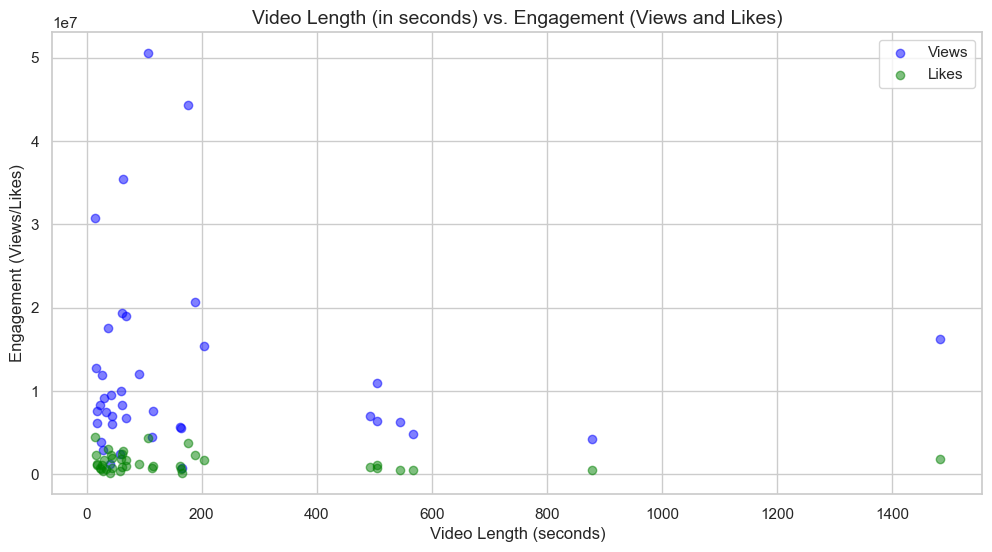

In [136]:
# To investigate how video length (duration) impacts engagement (views and likes), 
# we will analyze the relationship between the video duration and the engagement metrics (views and likes).

# Scatter plot to visualize the relationship between video length and views/likes
plt.figure(figsize=(12, 6))

# Plot for video length vs. views
plt.scatter(video_df['durationSecs'], video_df['viewCount'], color='blue', alpha=0.5, label='Views')

# Plot for video length vs. likes
plt.scatter(video_df['durationSecs'], video_df['likeCount'], color='green', alpha=0.5, label='Likes')

plt.title('Video Length (in seconds) vs. Engagement (Views and Likes)', fontsize=14)
plt.xlabel('Video Length (seconds)', fontsize=12)
plt.ylabel('Engagement (Views/Likes)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()
